### Sample code for integrating the equations for moments/cumulants 
This notebook contains a sample code to integrate the equations for the moments (see eqs B4 in the paper) or the equations of the cumulants with a cumulant truncation scheme (CTM) as the boundary condition to close the hierarchy of eqs. 

The CTM scheme corresponds to a non trivial closure in the equations for the moments, see eqs C6 and C9, whereas it is easily applied to the equations of the cumulants as it is obtained just by posing $k_{\bar n+1} = k_{\bar n+2} =0$ where $n$ is the truncation level of the hierarchy and $k_n$ is the $n-th$ cumulant. 

The introduction of a non vanishing multiplicative noise, $\sigma_m \neq 0$, introduces in the approximate truncated system of eqs for moments or cumulants a potential numerical instability. This, more or less, means that the basin of attraction of the initial conditions leading to the stationary solutions might shrink whereas all other initial conditions lead to a divergence of the system. We have verified that numerically the truncated equations for the cumulants are way easier to integrate and less prone to this numerical instability. 

In the first part of the notebook we report the code to integrate the cumulants equations and we provide two examples, to both evaluate stationary properties (the phase diagram) and response properties. 

In the second part, we integrate the equations for the moments. Implementing the boundary conditions for high level of truncation requires a great amount of time so we have provided the folder "functions" where such boundary condition evaluations have already been evaluated. Nevertheless, for clarity we have kept in the code the function "formula_appr" that exactly does this job.


In [15]:
import numpy as np
from scipy.optimize import root_scalar
import scipy.integrate as integrate
from math import factorial as fac
from matplotlib import pyplot as plt

#### Functions specifically for the moments integration part


In [16]:
######### FUNCTIONS #########

def Fcritical(sa,theta,sm,nu):
    m = 0 
    q = ( alpha-theta+(nu-1)*sm**2+(sa/sm)**2 ) /sm**2
    p = lambda x : np.exp(  q*np.log(1 + (sm/sa *x)**2 ) - (x/sm)**2 )
    Z = 2* integrate.quad(p,0, np.inf)[0]
    P = lambda x : p(x)/Z
    F = theta/(sa*sm) * 2*integrate.quad( lambda x : x*np.arctan((sm/sa)*x) * P(x),0,np.inf)[0]
    return F

def FCumulant(t,M,alpha,theta,sigma,sigmaM,nu):
    N = len(M)
    dxdt = np.zeros(N)
    
    
    X = np.ones(N+2) ; X[N] = 0 ; X[N+1] = 0
    X[:N] = M 
    
    dxdt[0] = theta*X[0] 
    dxdt[1] = sigma**2  
    
    for n in range(1,N+1):
        q = fac(n-1)
        
        A = np.sum( np.array( [X[i-1]*X[n-i-1]/ ( fac(i-1)*fac(n-i-1) ) for i in range(1,n-1+1)] ) )
        B = np.sum( np.array( [X[i-1]*X[n-i+1]/ ( fac(i-1)*fac(n-i) )for i in range(1,n+1)] ) )
        
        C = 0
        for i in range(1,n+1):
            for j in range(1,n-i+2):
                C = C + X[i-1]*X[j-1]*X[n+2-i-j-1]/ ( fac(i-1)*fac(j-1)*fac(n-i-j+1) )
                
        
        dxdt[n-1] = dxdt[n-1] + n*( (alpha-theta+nu*sigmaM**2)*X[n-1] + sigmaM**2/2 *(n-1)*X[n-1] + 
                                   sigmaM**2/2*q*A - X[n+1] - 3*fac(n-1)*B - q* C )
        
    return dxdt


def GAUSS_ICumulants(N,mu=0.01,std=0.01):
    X0 = np.zeros(N) #- 1
    X0[0] = mu; X0[1] = std**2 
    return X0

def Cumulant_perturbation(eps,K0):
    N = len(K0)
    Kpert = K0.copy() 
    Kpert[0] = K0[0] + eps

    return Kpert

######## Functions for initial condition #######

def DELTA_IC(N,Min):
    M = [Min**n for n in range(1,N+1)]
    return np.array(M)

def GAUSS_IC(N,mu,std):
    from scipy.stats import norm
    moms = [norm.moment(n, loc=mu, scale=std) for n in range(1,N+1)]
    return np.array(moms)


# First part: Cumulants Equations (B8)

### Stationary Properties

In [17]:
### PARAMETERS AND CRITICAL VALUE OF THE NOISE ###
alpha = 1  ; theta = 4 ; sigmaM = 0.8 ; nu = 0.5
f = lambda x: Fcritical(x,theta,sigmaM,nu) - 1/2
sigmaC = root_scalar(f,bracket=[0.1,3], method='toms748').root 
sigmas = list(np.linspace(1.60,sigmaC,60)) +list(np.linspace(sigmaC+0.01,2.2,40))

In [18]:
##### Parameters Integration
t0 = 0 ; tmax = 5e6 ; dt = 10 
t_eval =  np.arange(t0,tmax,dt) 

#### Choose hierarchy truncation
Ns = [4,6,8,10]

In [19]:
K0 = GAUSS_ICumulants(10,mu=1,std=np.sqrt(1.5))
print(K0)
FCumulant(1,K0,alpha,theta,1,sigmaM,.5)

[1.  1.5 0.  0.  0.  0.  0.  0.  0.  0. ]


array([ -4.18, -27.94, -34.74, -63.72,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ])

In [20]:
C1inf = np.zeros((len(Ns),len(sigmas))) 
row = 0

for N in Ns:
    col = 0
    for sigma in sigmas:
        K0 = GAUSS_ICumulants(N,mu=1,std=1.5)
        R = integrate.solve_ivp(FCumulant,t_span=(t0,tmax),y0 = K0,
                        args=(alpha,theta,sigma,sigmaM,nu),
                        t_eval = [t_eval[-1]],method='Radau')
    
        if(R.success):
            C1inf[row,col] = R.y[0,-1]
            col = col + 1
        else:
            print('sigma = {} failed'.format(sigma))
    row = row + 1
    print('N = {} has finished'.format(N))

N = 4 has finished
N = 6 has finished
N = 8 has finished
N = 10 has finished


Text(0.5, 1.0, '$\\sigma_m = $0.8')

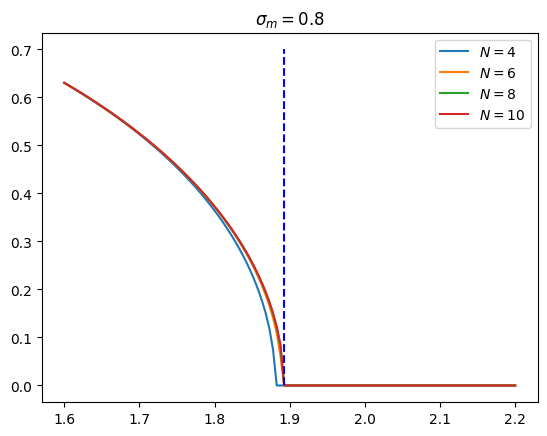

In [21]:
plt.figure()
for i in range(C1inf.shape[0]):
    plt.plot(sigmas,C1inf[i,:],label='$N = ${}'.format(Ns[i]))
    
plt.legend()
plt.vlines(sigmaC,0,0.7,color='b',linestyle='--')
plt.title('$\\sigma_m = ${}'.format(sigmaM))

### Response Properties

In [7]:
# Parameters of the integration (different dt at the beginning for the log plot)
t0 = 0 ; t1 = 10 ; dt1 = 0.01 
tmax = 5e6 ; dt = 10 ;
t_eval = np.array( list(np.arange(t0,t1,dt1)) + list( np.arange(t1,tmax,dt) ) )

#### AT THE TRANSITION ####
sigma = sigmaC

#### Choosing the truncation level of the hierarchy ####
Ns = [4,6,8,10,14,18,22]

In [8]:
finalK = [] ; 

for N in Ns:
        K0 = GAUSS_ICumulants(N,mu=1,std=1.5)
        R = integrate.solve_ivp(FCumulant,t_span=(t0,tmax),y0 = K0,
                            args=(alpha,theta,sigma,sigmaM,nu),
                            t_eval = t_eval,method='Radau')
    
        if(R.success):
            finalK.append(R.y[:,-1])
        else:
            print('N = {} failed'.format(N))
            break
        print('N = {} has finished'.format(N))

N = 4 has finished
N = 6 has finished
N = 8 has finished
N = 10 has finished
N = 14 has finished
N = 18 has finished
N = 22 has finished


In [9]:
#### RESPONSE PROPERTIES ####
RespKCritical = []
eps = 0.01 ; 

for i in range(len(Ns)):
    Kas = finalK[i] ; N = Ns[i]
    Kpert = Cumulant_perturbation(eps,Kas)
    
    deltaK = integrate.solve_ivp(FCumulant,t_span=(t0,tmax),y0 = Kpert,
                        args=(alpha,theta,sigma,sigmaM,nu),
                        t_eval = t_eval,method='Radau')
    
    
    RespKCritical.append( (deltaK.y[0]-Kas[0])/eps )
    print('N = {} has finished'.format(N))

N = 4 has finished
N = 6 has finished
N = 8 has finished
N = 10 has finished
N = 14 has finished
N = 18 has finished
N = 22 has finished


In [10]:
#### CLOSE (above) TO THE TRANSITION ####
sigma = sigmaC + 0.1*sigmaC

In [11]:
finalKClose = []

for N in Ns:
    K0 = GAUSS_ICumulants(N,mu=1,std=1.5)
    R = integrate.solve_ivp(FCumulant,t_span=(t0,tmax),y0 = K0,
                        args=(alpha,theta,sigma,sigmaM,nu),
                        t_eval = t_eval,method='Radau')#'DOP853')#'RK45')#'Radau')#'BDF'
    
    if(R.success):
        finalKClose.append(R.y[:,-1])
    else:
        print('N = {} failed'.format(N))
        break
    print('N = {} has finished'.format(N))

N = 4 has finished
N = 6 has finished
N = 8 has finished
N = 10 has finished
N = 14 has finished
N = 18 has finished
N = 22 has finished


In [12]:
RespKClose = []
eps = 0.01 ; 

for i in range(len(Ns)):
    Kas = finalKClose[i] ; N = Ns[i]
    Kpert = Cumulant_perturbation(eps,Kas)
    
    deltaK = integrate.solve_ivp(FCumulant,t_span=(t0,tmax),y0 = Kpert,
                        args=(alpha,theta,sigma,sigmaM,nu),
                        t_eval = t_eval,method='Radau')
    
    
    RespKClose.append( (deltaK.y[0]-Kas[0])/eps )
    print('N = {} has finished'.format(N))

N = 4 has finished
N = 6 has finished
N = 8 has finished
N = 10 has finished
N = 14 has finished
N = 18 has finished
N = 22 has finished


<IPython.core.display.Javascript object>


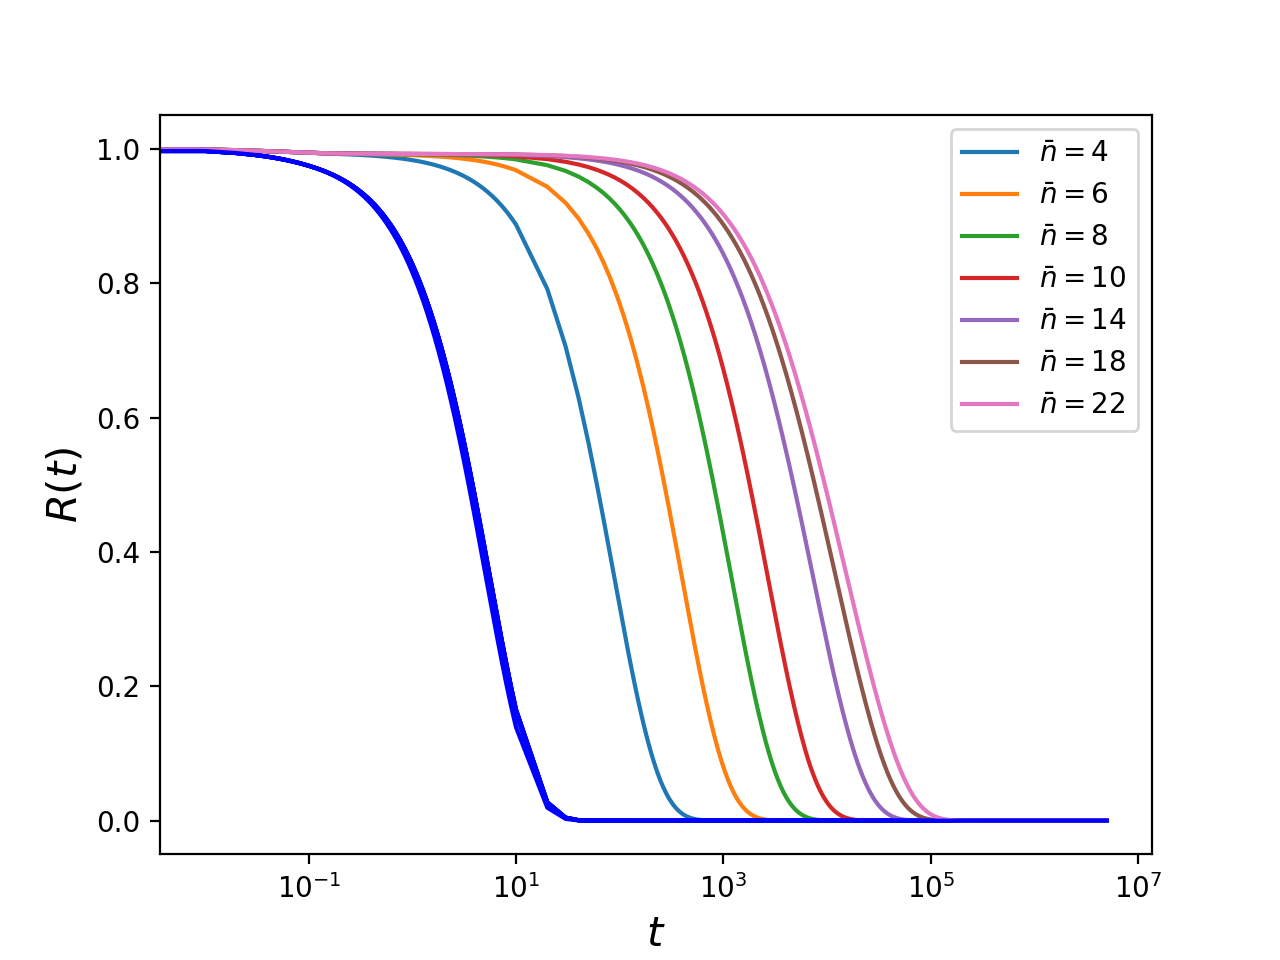

Text(0, 0.5, '$R(t)$')

In [13]:
plt.figure()
for i in range(len(Ns)):
    plt.plot(t_eval,RespKCritical[i],label='$\\bar n = ${}'.format(Ns[i]))
    plt.plot(t_eval,RespKClose[i],'b')

plt.legend()
ax = plt.gca() ; ax.set_xscale('log')
plt.xlabel('$t$',size=15)
plt.ylabel('$R(t)$',size=15)
#plt.title('$\\sigma_m = ${}'.format(sigmaM));

# Second part: Moments Equations (B4) 

### Stationary Properties

In [14]:
#from sympy import bell , symbols
#from scipy.special import binom
#from sympy.utilities.lambdify import lambdify
#from sympy import MatrixSymbol

# def formula_appr(N):  ### this is the function to write the boundary conditions for the moments equations
#     M = MatrixSymbol('M',1, N)
#     # M_{N+1} approx
#     MN1 = - np.sum( [(-1)**(k-1) * fac(k-1) * bell(N+1,k,M) for k in range(2,N+1+1)] )
#     MN1 = MN1.simplify()
#     # M_{N+2} approx
#     a = (N+2)*MN1*M[0,0] 
#     b = np.sum( [binom(N+2,k)*M[0,k-1]*M[0,N+2-k-1] for k in range(2,N+1) ] )
#     c = np.sum( [(-1)**(k-1) * fac(k-1)* bell(N+2,k,M) for k in range(3,N+2+1)] )
#     MN2 = a + b/2 - c
#     MN2 = MN2.simplify()
    
#     mn1 = lambdify(M,MN1) 
#     mn2 = lambdify(M,MN2)
#     return mn1 , mn2

def F(t,M,alpha,theta,sigma,sigmaM,nu,mn1,mn2):
    N = len(M)
    dxdt = np.zeros(N)
    MN1 = mn1(np.reshape(M,(1,N))) ; MN2 = mn2(np.reshape(M,(1,N)))
    
    X = np.ones(N+4) ; X[2:-2] = M ; X[N+2] = MN1 ; X[N+3] = MN2
    
    
    for n in range(1,N+1):
        dxdt[n-1] = n * ( (alpha-theta+sigmaM**2*(nu+(n-1)/2) )*X[n+1]
                        -X[n+3]+theta*X[2]*X[n] 
                        + sigma**2/2*(n-1)*X[n-1] )
        
    return dxdt

In [15]:
sigmaM = 0.5 ; Ns = [4,6,8,10]

In [16]:
M1inf = np.zeros((len(Ns),len(sigmas))) 

row = 0
for N in Ns:
    col = 0
    for sigma in sigmas:
        M0 = GAUSS_IC(mu=1,std=1,N=N)#GAUSS_IC(mu=0.1,std=0.01,N=N)
        #### Loading the function giving the cumulant truncation scheme for the moments equations #### 
        mn1 = dill.load(open('./functions/formula_mn1_'+str(N), "rb"))
        mn2 = dill.load(open('./functions/formula_mn2_'+str(N), "rb"))
    
        r = integrate.solve_ivp(F,t_span=(t0,tmax),y0 = M0,
                            args=(alpha,theta,sigma,sigmaM,nu,mn1,mn2),
                            t_eval = t_eval,method='Radau')
    
    
        if(r.success):
            M1inf[row,col] = r.y[0,-1]
            col = col + 1
            
        else:
            print('N = {} failed'.format(N))
            break
    row = row + 1
    print('N = {} has finished'.format(N))
    

N = 4 has finished
N = 6 has finished
N = 8 has finished
N = 10 has finished


<IPython.core.display.Javascript object>


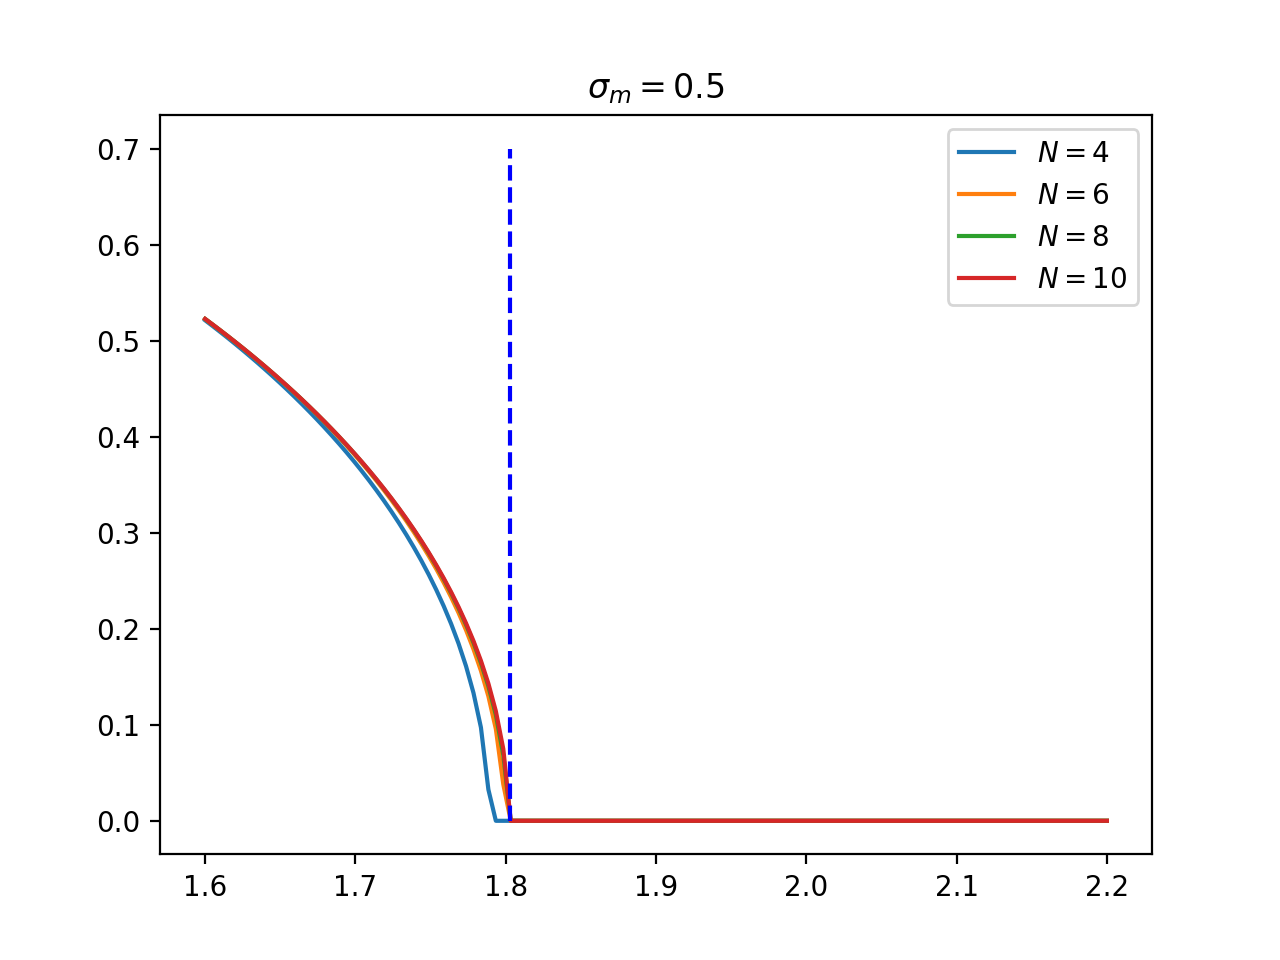

In [19]:
f = lambda x: Fcritical(x,theta,sigmaM,nu) - 1/2
sigmaC = root_scalar(f,bracket=[0.1,3], method='toms748').root 

plt.figure()
for i in range(M1inf.shape[0]):
    plt.plot(sigmas,M1inf[i,:],label='$N = ${}'.format(Ns[i]))
    
plt.legend()
plt.vlines(sigmaC,0,0.6,color='b',linestyle='--')
plt.title('$\\sigma_m = ${}'.format(sigmaM));